# imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
import urllib3
import math
import datetime
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import PredictionErrorDisplay

In [2]:
df = pd.read_csv(r'C:\Users\Amanda\Downloads\MTA_Subway_Hourly_Ridership__Beginning_February_2022.csv')

# data formatting / cleaning

In [3]:
df["datetime"] = pd.to_datetime(df["transit_timestamp"], format='%m/%d/%Y %I:%M:%S %p')

In [4]:
df["Weekday"] = np.where(df["datetime"].dt.day_name().isin(["Saturday","Sunday"]), 0, 1)
df["SingleLine"] = np.where(df["routes"].str.contains(",", na=False), 0, 1)
df["Peak"] = np.where(df["datetime"].dt.hour.isin([8,17]), 1, 0)
df["day"] = df["datetime"].dt.day_name()
df["hour"] = df["datetime"].dt.hour
df["date"] = df["datetime"].dt.year.astype(str) + "-" + df["datetime"].dt.month.astype(str) + "-" + df["datetime"].dt.day.astype(str)
df["year_month"] = df["datetime"].dt.year.astype(str) + "-" + df["datetime"].dt.month.astype(str)

# data exploration - graphs

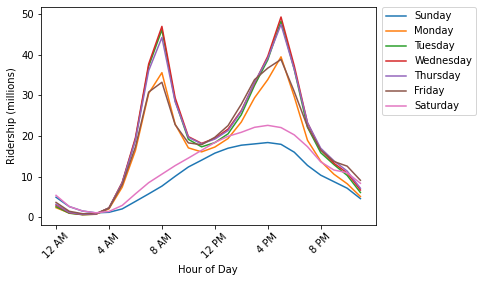

In [5]:
hour_dayofweek_ridership = df.groupby(["hour","day"])["ridership"].sum()

for day in ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]:
    day_byhour_ridership = hour_dayofweek_ridership.loc[:,day]
    plt.plot(day_byhour_ridership.index, day_byhour_ridership, label=day)

plt.xticks(rotation=45)
plt.xlabel("Hour of Day")
plt.xticks([0,4,8,12,16,20],["12 AM","4 AM","8 AM","12 PM","4 PM","8 PM"])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.ylabel("Ridership (millions)")
plt.yticks(np.arange(0, 50000001, 10000000),["0","10","20","30","40","50"])
plt.show()

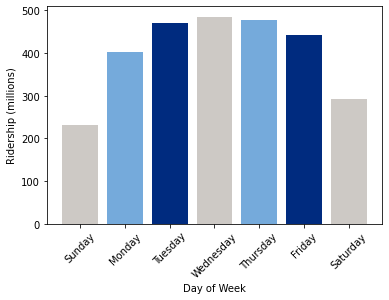

In [7]:
day_ridership = df.groupby(["day"])["ridership"].sum()

days_of_week = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
mapping = {day: i for i, day in enumerate(days_of_week)}
key= day_ridership.index.map(mapping)
day_ridership = day_ridership.iloc[key.argsort()]

rgb = [(205, 201, 197), (117, 170, 219), (0, 43, 127)]
colors = [tuple(t / 255 for t in x) for x in rgb]

plt.bar(day_ridership.index, day_ridership,color = colors)
plt.xticks(rotation=45)
plt.xlabel("Day of Week")
plt.ylabel("Ridership (millions)")
plt.yticks(np.arange(0, 500000001, 100000000),["0","100","200","300","400","500"])
plt.show()

# cluster

In [10]:
feature_column = df.groupby("station_complex")["ridership"].sum()
X = feature_column.values.reshape(-1,1)
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
cluster_labels = kmeans.labels_

c:\Users\Amanda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [11]:
clusters = pd.DataFrame(feature_column)
clusters["cluster_label"] = cluster_labels
clusters.sort_values(by="ridership")

,ridership,cluster_label
station_complex,,
"Broad Channel (A,S)",147631,0
"Beach 105 St (A,S)",192917,0
Tompkinsville,226766,0
"Beach 98 St (A,S)",277216,0
Beach 44 St (A),357110,0
...,...,...
"Fulton St (A,C,J,Z,2,3,4,5)",42993959,1
"14 St-Union Sq (L,N,Q,R,W,4,5,6)",50533037,1
"34 St-Herald Sq (B,D,F,M,N,Q,R,W)",56928398,1


In [12]:
df = df.merge(clusters, on="station_complex")
df = pd.get_dummies(df, columns=["cluster_label"])
df.head()

,transit_timestamp,station_complex_id,station_complex,borough,routes,payment_method,ridership_x,transfers,latitude,longitude,...,datetime,Weekday,SingleLine,Peak,day,hour,ridership_y,cluster_label_0,cluster_label_1,cluster_label_2
0,08/04/2022 04:00:00 AM,H007,1 Av (L),M,L,omny,11,0,40.730953,-73.981628,...,2022-08-04 04:00:00,1,1,0,Thursday,4,14199226,1,0,0
1,02/13/2023 03:00:00 AM,H007,1 Av (L),M,L,omny,10,0,40.730953,-73.981628,...,2023-02-13 03:00:00,1,1,0,Monday,3,14199226,1,0,0
2,03/08/2023 04:00:00 AM,H007,1 Av (L),M,L,omny,4,0,40.730953,-73.981628,...,2023-03-08 04:00:00,1,1,0,Wednesday,4,14199226,1,0,0
3,03/23/2023 03:00:00 AM,H007,1 Av (L),M,L,omny,10,0,40.730953,-73.981628,...,2023-03-23 03:00:00,1,1,0,Thursday,3,14199226,1,0,0
4,04/03/2023 05:00:00 AM,H007,1 Av (L),M,L,omny,28,0,40.730953,-73.981628,...,2023-04-03 05:00:00,1,1,0,Monday,5,14199226,1,0,0


In [54]:
df.head()

,transit_timestamp,station_complex_id,station_complex,borough,routes,payment_method,ridership_x,transfers,latitude,longitude,...,SingleLine,Peak,day,hour,ridership_y,cluster_label_0,cluster_label_1,cluster_label_2,date,year_month
0,08/04/2022 04:00:00 AM,H007,1 Av (L),M,L,omny,11,0,40.730953,-73.981628,...,1,0,Thursday,4,14199226,1,0,0,2022-8-4,2022-8
1,02/13/2023 03:00:00 AM,H007,1 Av (L),M,L,omny,10,0,40.730953,-73.981628,...,1,0,Monday,3,14199226,1,0,0,2023-2-13,2023-2
2,03/08/2023 04:00:00 AM,H007,1 Av (L),M,L,omny,4,0,40.730953,-73.981628,...,1,0,Wednesday,4,14199226,1,0,0,2023-3-8,2023-3
3,03/23/2023 03:00:00 AM,H007,1 Av (L),M,L,omny,10,0,40.730953,-73.981628,...,1,0,Thursday,3,14199226,1,0,0,2023-3-23,2023-3
4,04/03/2023 05:00:00 AM,H007,1 Av (L),M,L,omny,28,0,40.730953,-73.981628,...,1,0,Monday,5,14199226,1,0,0,2023-4-3,2023-4


In [62]:
latitude = "40.730953"
longitude = "-73.981628"
df[(abs(df["latitude"] - 40.730953) < 1e-4) & (abs(df["longitude"]- -73.981628) < 1e-4)].iloc[0]

transit_timestamp                            08/04/2022 04:00:00 AM
station_complex_id                                             H007
station_complex                                            1 Av (L)
borough                                                           M
routes                                                            L
payment_method                                                 omny
ridership_x                                                      11
transfers                                                         0
latitude                                                  40.730953
longitude                                                -73.981628
Georeference          POINT (-73.98162841796875 40.730953216552734)
itsuid                        2022-08-04T04:00:00H0071 Av (L)MLomny
datetime                                        2022-08-04 04:00:00
Weekday                                                           1
SingleLine                                      

In [65]:
# Load your dataset
data = df

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Group the data by latitude and longitude, and calculate the sum of transfers for each group
grouped_data = data.groupby(['latitude', 'longitude'])['ridership_x'].sum().reset_index()

# Create a base map
m = folium.Map(location=[data['latitude'].mean(), data['longitude'].mean()], zoom_start=12, tiles='Stamen Toner')

# Define a function to scale the radius based on the sum of transfers
def scale_radius(ridership):
    # You can adjust this scaling factor to make the circles larger or smaller as needed
    #scaling_factor = 0.001  # Experiment with this value
    #return ridership * scaling_factor
    return math.log(ridership,1.5) * 0.01

def color(latitude, longitude):
    station = data[(abs(data["latitude"] - latitude) < 1e-4) & (abs(data["longitude"]- longitude) < 1e-4)].iloc[0]
    if station["cluster_label_1"] == 0 and station["cluster_label_2"] == 0:
        return "darkblue"
    elif station["cluster_label_1"] == 1 and station["cluster_label_2"] == 0:
        return "lightblue"
    else:
        return "gray"

# Add CircleMarkers with radius proportional to the sum of transfers for each location
for index, row in grouped_data.iterrows():
    radius = scale_radius(row['ridership_x'])
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=radius,
        color=color(row['latitude'], row['longitude']),
        fill=True,
        fill_color= color(row['latitude'], row['longitude']),
        fill_opacity=0.6,
        popup=f"Total Ridership: {row['ridership_x']}"
    ).add_to(m)

# Display the map
m

# Decision Tree Regression

In [14]:
daily_ridership = df.groupby(["date","Weekday","SingleLine","Peak","cluster_label_1","cluster_label_2"])["ridership_x"].sum().reset_index()
daily_ridership["month"] = daily_ridership["date"].str.split("-").str[1]
daily_ridership = daily_ridership.groupby(["month","Weekday","SingleLine","Peak","cluster_label_1","cluster_label_2"])["ridership_x"].mean().reset_index()
daily_ridership.head()

,month,Weekday,SingleLine,Peak,cluster_label_1,cluster_label_2,ridership_x
0,1,0,0,0,0,0,554040.111111
1,1,0,0,0,0,1,78945.000000
2,1,0,0,0,1,0,422852.666667
3,1,0,0,1,0,0,72191.666667
4,1,0,0,1,0,1,9703.111111


In [15]:
X_linreg = daily_ridership
y = X_linreg["ridership_x"]
X_linreg = X_linreg.drop(columns=["ridership_x"])

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_linreg, y, test_size=0.2)

In [39]:
reg_decision_tree = DecisionTreeRegressor().fit(X_train, y_train)

In [40]:
reg_decision_tree.score(X_test, y_test)

0.9875954130530419

In [41]:
n = 240
k = 6
1 - ((1- reg_decision_tree.score(X_test, y_test) )*(n-1)/(n-k-1))

0.987275981629515

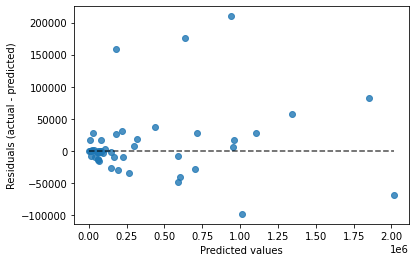

In [42]:
disp = PredictionErrorDisplay.from_estimator(reg_decision_tree, X_test, y_test)
plt.show()

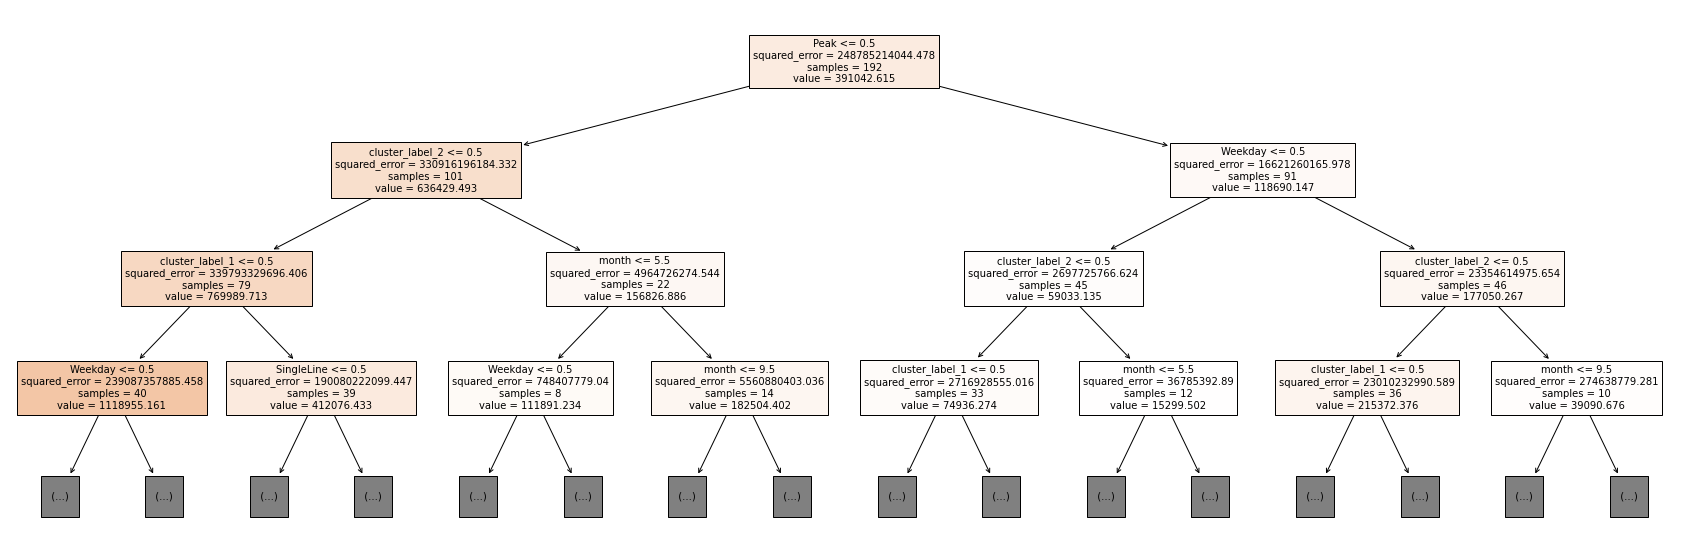

In [43]:
plt.figure(figsize=(30,10))
plot_tree(reg_decision_tree, filled=True, feature_names=X_linreg.columns, fontsize=10,max_depth=3)
plt.show()